## Importing Libraries

In [27]:
import json
import matplotlib.pyplot as plt

import asyncio
from time import perf_counter
import aiohttp
import requests
from time import sleep
from tqdm import tqdm
from random import randint

### <font size="5">Initializing the default configuration</font> 

In [25]:
LOAD_BALANCER_URL = "http://localhost:8000"
payload = {
    "N":6,
    "schema":{"columns":["Stud_id","Stud_name","Stud_marks"],
    "dtypes":["Number","String","String"]},
    "shards":[  {"Stud_id_low":0, "Shard_id": "sh1", "Shard_size":4096},
                {"Stud_id_low":4096, "Shard_id": "sh2", "Shard_size":4096},
                {"Stud_id_low":8192, "Shard_id": "sh3", "Shard_size":4096},
                {"Stud_id_low":12288, "Shard_id": "sh4", "Shard_size":4096}],
    "servers":{ "Server0":["sh1","sh2"],
                "Server1":["sh3","sh4"],
                "Server3":["sh1","sh3"],
                "Server4":["sh4","sh2"],
                "Server5":["sh1","sh4"],
                "Server6":["sh3","sh2"]}
}

response = requests.post(LOAD_BALANCER_URL+"/init", json=payload)
print(response.text)



{"message":"Configured Database","status":"success"}


### A-1  <font size="5">Sending 10,000 read and write requests on above configuration</font> 


In [12]:
# Making 10,000 synchronus write requests
MIN_STUDENT_ID, MAX_STUDENT_ID = 0, 16384
start = perf_counter()
for i in tqdm(range(10000)):
    student_id = i
    student_name = "student_"+str(i)
    student_marks = i%100
    payload = { "data": [ {"Stud_id": student_id,"Stud_name": student_name, "Stud_marks": student_marks} ]
                }
    
    response = requests.post(LOAD_BALANCER_URL+"/write", json=payload)
    if response.status_code != 200:
        print("Error in write request")
        print(response.text)
        break
end = perf_counter()

print("Write requests done!")
print(f"Time taken: {end-start} seconds")    

100%|██████████| 10000/10000 [13:47<00:00, 12.09it/s]

Write requests done!
Time taken: 827.0510162250002 seconds


In [26]:
REQ_COUNT = 3000
# Making 10,000 asynchronus write requests
async def write(session, payload):
    async with session.post(LOAD_BALANCER_URL+"/write", json=payload) as r:
        if r.status != 200:
            r.raise_for_status()
            print("Error in write request")
        res=await r.text()
        return res
    
async def write_all(session, payload_list):
    tasks = []
    for payload in payload_list:
        task = asyncio.create_task(write(session, payload))
        tasks.append(task)
        
    print(f"<+> Sent all {len(payload_list)} write requests ")
    res = await asyncio.gather(*tasks)
    return res

shard_count = 4
block_size = MAX_STUDENT_ID//shard_count   
start = perf_counter()
async with aiohttp.ClientSession() as session:
    payload_list = []
    i = 0
    while i <= MAX_STUDENT_ID:
        student_id = i
        student_name = "student_"+str(i)
        student_marks = i%100
        payload = { "data": [ {"Stud_id": student_id,"Stud_name": student_name, "Stud_marks": student_marks} ]
                    }
        payload_list.append(payload)
        
        if len(payload_list) == REQ_COUNT:
            break
        
        i+=1
        if i%block_size == REQ_COUNT//shard_count:
            i= (1+i//block_size)*block_size
        
    htmls = await write_all(session, payload_list)
end = perf_counter()
print(f"Time taken to complete {REQ_COUNT} requests: {end-start:.2f} seconds")

<+> Sent all 3000 write requests 
Time taken to complete 3000 requests: 107.83 seconds


In [31]:
# Making 10,000 asynchronus read requests

REQ_COUNT = 3000
async def read(session, payload):
    async with session.post(LOAD_BALANCER_URL+"/read", json=payload) as r:
        if r.status != 200:
            r.raise_for_status()
            print("Error in read request")
        res=await r.text()
        return res
    
async def read_all(session, payload_list):
    tasks = []
    for payload in payload_list:
        task = asyncio.create_task(read(session, payload))
        tasks.append(task)
        
    print(f"<+> Sent all {len(payload_list)} read requests ")
    res = await asyncio.gather(*tasks)
    return res

shard_count = 4
block_size = MAX_STUDENT_ID//shard_count   
start = perf_counter()
async with aiohttp.ClientSession() as session:
    payload_list = []
    i = 0
    while i <= MAX_STUDENT_ID:
        student_id = i
        student_name = "student_"+str(i)
        student_marks = i%100
        
        low = randint(MIN_STUDENT_ID, MAX_STUDENT_ID)
        high = randint(low, min(MAX_STUDENT_ID, low + randint(1, 100)))
        
        payload = { "Stud_id": {"low":0, "high":14000}   }
        payload_list.append(payload)
        
        if len(payload_list) == REQ_COUNT:
            break
        
        i+=1
        if i%block_size == REQ_COUNT//shard_count:
            i= (1+i//block_size)*block_size
        
    htmls = await read_all(session, payload_list)
end = perf_counter()
print(f"Time taken to complete {REQ_COUNT} requests: {end-start:.2f} seconds")

<+> Sent all 3000 read requests 
Time taken to complete 3000 requests: 75.62 seconds


In [18]:
## Make sure that the load balancer is running and no servers have been added yet (Servers will be added from here)

# Creating 3 servers for testing


REQUEST_COUNT = 10000

serv_names = ["serv_1", "serv_2", "serv_3"]

json_data = {
    "n": 3,
    "hostnames": serv_names
}

response = requests.post(LOAD_BALANCER_URL+"/add", json=json_data)
response.text

'{"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}'

In [19]:

async def fetch(session):
    async with session.get(LOAD_BALANCER_URL+"/home") as r:
        if r.status != 200:
            r.raise_for_status()
        res=await r.text()
        return res
    
async def fetch_all(session, req_count):
    tasks = []
    for i in range(req_count):
        task = asyncio.create_task(fetch(session))
        tasks.append(task)
    print(f"<+> Sent all {req_count} requests ")
    res = await asyncio.gather(*tasks)
    return res

In [20]:
start = perf_counter()
async with aiohttp.ClientSession() as session:
    htmls = await fetch_all(session,    REQUEST_COUNT)
end = perf_counter()
print(f"Time taken to complete {REQUEST_COUNT} requests: {end-start:.2f} seconds")

<+> Sent all 10000 requests 
Time taken to complete 10000 requests: 46.68 seconds


In [21]:
# Count occurrences of each server
data = [json.loads(html) for html in htmls]
server_counts = dict(zip(serv_names, [0]*len(serv_names)))
for entry in data:
    server_name = entry["message"].split(":")[1]
    if server_name in server_counts:
        server_counts[server_name] += 1
    else:
        server_counts[server_name] = 1


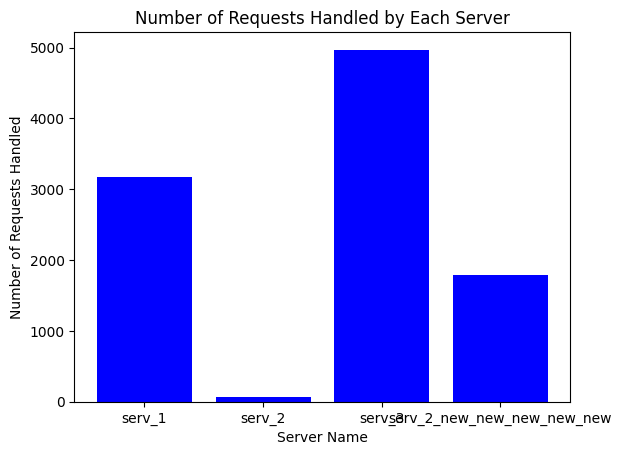

In [22]:
# Plot the bar graph
servers = list(server_counts.keys())
counts = list(server_counts.values())

plt.bar(servers, counts, color='blue')
plt.xlabel('Server Name')
plt.ylabel('Number of Requests Handled')
plt.title('Number of Requests Handled by Each Server')
plt.show()


In [17]:
# Remove the Added Servers
response = requests.delete(LOAD_BALANCER_URL+"/rm", json=json_data)
response.text

'{"message":{"N":0,"replicas":[]},"status":"successful"}'

### A-2  <font size="5"> Increment N from 2 to 6 and launch 10000 requests on each such increment</font> 

In [18]:
def get_server_loads(htmls, server_list):
    data = [json.loads(html) for html in htmls]
    server_load = dict(zip(server_list, [0]*len(server_list)))
        
    for entry in data:
        server_name = entry["message"].split(":")[1]
        server_load[server_name] += 1

    return server_load



{"message":{"N":1,"replicas":["serv_1"]},"status":"successful"}
{"message":{"N":2,"replicas":["serv_1","serv_2"]},"status":"successful"}
#REP:  {"message":{"N":2,"replicas":["serv_1","serv_2"]},"status":"successful"}
<+> Sent all 10000 requests 
Time taken to complete 10000 requests with 2 servers: 16.98 seconds
{"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}
#REP:  {"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}
<+> Sent all 10000 requests 
Time taken to complete 10000 requests with 3 servers: 17.25 seconds
{"message":{"N":4,"replicas":["serv_1","serv_2","serv_3","serv_4"]},"status":"successful"}
#REP:  {"message":{"N":4,"replicas":["serv_1","serv_2","serv_3","serv_4"]},"status":"successful"}
<+> Sent all 10000 requests 
Time taken to complete 10000 requests with 4 servers: 17.60 seconds
{"message":{"N":5,"replicas":["serv_1","serv_2","serv_3","serv_4","serv_5"]},"status":"successful"}
#REP:  {"message":{"N":5,"replic

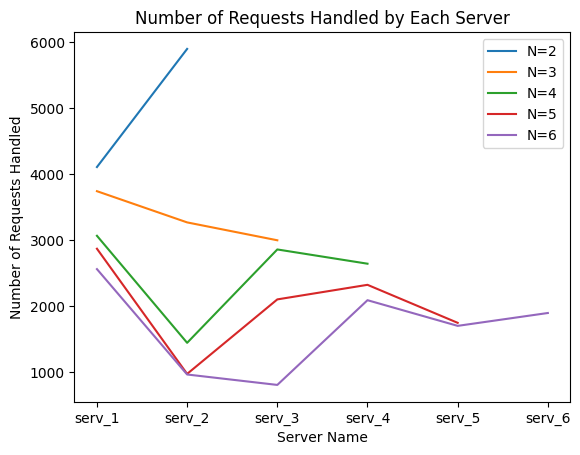

{"message":{"N":0,"replicas":[]},"status":"successful"}


In [26]:
server_names = []
max_min_load_diff = []
for server_count in range(2, 7):
    
    while server_count > len(server_names):
        new_server_name = "serv_"+str(len(server_names)+1)
        response = requests.post(LOAD_BALANCER_URL+"/add", json={"n":1, "hostnames":[new_server_name]})
        print(response.text)
        if response.status_code == 200:
            server_names.append("serv_"+str(len(server_names)+1))
    sleep(1)
    response = requests.get(LOAD_BALANCER_URL+"/rep")
    print("#REP: ", response.text)
        
    
    # REQUEST_COUNT = 100
    start = perf_counter()
    async with aiohttp.ClientSession() as session:
        htmls = await fetch_all(session, REQUEST_COUNT)
    end = perf_counter()
    print(f"Time taken to complete {REQUEST_COUNT} requests with {len(server_names)} servers: {end-start:.2f} seconds")
    
    server_load = get_server_loads(htmls, server_names)
    
    # print(server_names) 
    # print(server_load)
    # print(server_load.values())
    
    max_min_load_diff.append(max(server_load.values()) - min(server_load.values()))
    plt.plot(server_names, server_load.values(), label=f"N={len(server_names)}")
   
plt.xlabel('Server Name')
plt.ylabel('Number of Requests Handled')
plt.title('Number of Requests Handled by Each Server')
plt.legend()
plt.show() 
delete_response = requests.delete(LOAD_BALANCER_URL+"/rm", json={"n":len(server_names), "hostnames":server_names})
print(delete_response.text)

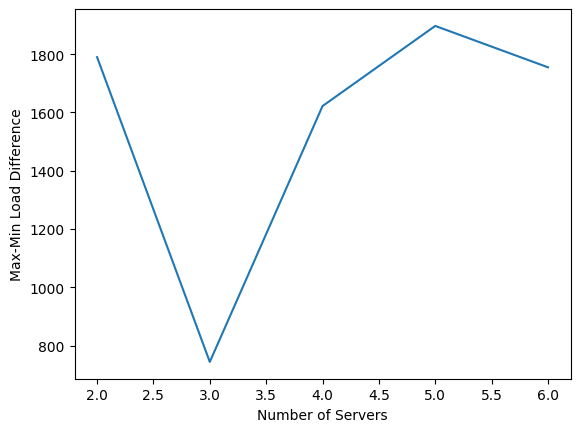

In [27]:
# Plot the max-min load difference line graph
plt.plot(range(2,7), max_min_load_diff)
plt.xlabel('Number of Servers')
plt.ylabel('Max-Min Load Difference')
plt.show()

### A-3  <font size="5">Test all endpoints</font> 

In [119]:
serv_names = ["serv_1", "serv_2", "serv_3"]

json_data = {
    "n": 4,
    "hostnames": serv_names
}



In [120]:
#  testing /add endpoint
response = requests.post(LOAD_BALANCER_URL+"/add", json=json_data)
response.text

'{"message":{"N":4,"replicas":["serv_1","serv_2","serv_3","8ebb95"]},"status":"successful"}'

In [121]:
# testing /rep endpoint
response = requests.get(LOAD_BALANCER_URL+"/rep")
response.text

'{"message":{"N":4,"replicas":["serv_1","serv_2","serv_3","8ebb95"]},"status":"successful"}'

In [122]:
# testing /rm endpoint
response = requests.delete(LOAD_BALANCER_URL+"/rm", json={
    "n":2,
    "hostnames":["serv_1"]
})
response.text

'{"message":{"N":2,"replicas":["serv_3","8ebb95"]},"status":"successful"}'

In [123]:
# testing /rep endpoint
response = requests.get(LOAD_BALANCER_URL+"/rep")
response.text

'{"message":{"N":2,"replicas":["serv_3","8ebb95"]},"status":"successful"}'

In [126]:
# testing /home endpoint
response = requests.get(LOAD_BALANCER_URL+"/home")
response.text

'{"message":"Hello from Server:serv_3","status":"successful"}'

In [127]:
# testing /heartbeat endpoint
response = requests.get(LOAD_BALANCER_URL+"/heartbeat")
response.text

'""'

In [129]:
#  testing /rm endpoint
response = requests.delete( LOAD_BALANCER_URL+"/rm", json={"n":2 , "hostnames":[]})
response.text

'{"message":{"N":0,"replicas":[]},"status":"successful"}'

Testing server respawn on failure

In [5]:


LOAD_BALANCER_URL = "http://localhost:5000"
REQUEST_COUNT = 10000

serv_names = ["serv_1", "serv_2", "serv_3"]

json_data = {
    "n": 3,
    "hostnames": serv_names
}

In [7]:

response =requests.post(LOAD_BALANCER_URL+"/add", json=json_data)
response.text

'{"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}'

Now run ```sudo docker rm -f serv_1``` in a terminal

In [8]:
response = requests.get(LOAD_BALANCER_URL+"/rep")
response.text

'{"message":{"N":3,"replicas":["serv_2","serv_3","serv_1_new"]},"status":"successful"}'